SIA DU Jack | LAROYE Ambroise

## 1 Tracking simple objects in videos

### 1.1 Particle Filters

In this exercise, you will implement a simple object tracker based on the Particle Filter. Some test video sequences can be downloaded from the link below :
https://drive.google.com/file/d/1k4RoERodDDEmLUzy_EhYPUaMlfzkRKVP/view?usp=drive_link

A motivating example is given in sequence seq23.avi that shows the tracking result of a (standard) Particle Filter on a real sequence.
The tracked area (object) is initialized by the user and its shape is assumed to be fixed. We will consider here a rectangle, parameterized by the position of its center.The hidden state is thus represented by a 2-dimensional vector.

Transition function.
We are interested in the scenario where no apriori information on the movement of the tracked object is available.The transition model is therefore given by:

Xk = Xk-1 + Vk

where Vk N(0, Sigma) is a Gaussian white noise, Sigma is a diagonal matrix.

**Likelihood function.** <br>
We calculate a normalized color histogram (Nb bins) associated with the tracked area and those associated with the particles in order to approximate the likelihood function. More precisely, at a time instant k, each particle xik i=1, ..., N will define an area on the image. A histogram is then calculated from this area.The likelihood function is constructed by comparing the obtained histogram with the reference histogram (the one associated with the tracked area). Here we assume that the histogram associated with the tracked area is time invariant.The distance between two color histograms h and h' is defined as:

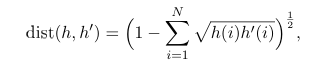

où h(i) et h′(i) sont les i-èmes bins des histogrammes h et h′ , respectivement. La fonction de vraisemblance est alors approximée par :

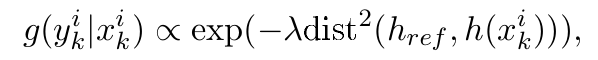

where h ref is the reference histogram, h(x i k) is the histogram associated with particle x i k, and C is a constant. Details of the tracking algorithm are given below:"

#### **Step 1:**
Initialize the tracked area by determining the position of center of rectangle and its size.

In [1]:
import numpy as np
import cv2

def initialize_tracked_area(video_path, initial_position, half_width, half_height):
    """
    Initialize the tracked area by determining the position of the center of the rectangle and its size.
    
    Args:
        video_path (str): path to the video file
        initial_position (tuple): (x_center, y_center) initial position of the tracked area
        half_width (int): half of the width of the rectangle
        half_height (int): half of the height of the rectangle
    
    Returns:
        cap (cv2.VideoCapture): video capture object
        image (np.ndarray): the first frame of the video
        s_init (np.ndarray): initial state vector [x_center, y_center, vx, vy]
        half_width (int): half width of the bounding box
        half_height (int): half height of the bounding box
    """
    # Open video capture
    cap = cv2.VideoCapture(video_path)
    ret, image = cap.read()
    
    if not ret:
        print("Error: Could not read the first frame from video.")
        return None, None, None, None, None

    # Initialize the state (x_center, y_center, vx, vy)
    s_init = np.array([initial_position[0], initial_position[1], 0, 0])

    return cap, image, s_init, half_width, half_height

def draw_initial_rectangle(image, s_init, half_width, half_height):
    """
    Draw the initial rectangle for the tracked area on the image.
    
    Args:
        image (np.ndarray): the image to draw the rectangle on
        s_init (np.ndarray): initial state [x_center, y_center, vx, vy]
        half_width (int): half width of the bounding box
        half_height (int): half height of the bounding box
    
    Returns:
        image_with_rectangle (np.ndarray): the image with the rectangle drawn on
    """
    x_center, y_center = s_init[:2].astype(int)
    
    # Top-left and bottom-right corners of the rectangle
    top_left = (x_center - half_width, y_center - half_height)
    bottom_right = (x_center + half_width, y_center + half_height)
    
    # Draw the rectangle on the image
    image_with_rectangle = image.copy()
    cv2.rectangle(image_with_rectangle, top_left, bottom_right, (0, 255, 0), 2)  # Green rectangle with thickness 2
    return image_with_rectangle

# Example usage of Step 1
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Draw the initial rectangle on the image
    image_with_rectangle = draw_initial_rectangle(image, s_init, half_width, half_height)
    
    # Display the image with the rectangle
    cv2.imshow("Initial Tracked Area", image_with_rectangle)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.destroyAllWindows()

    # Optionally, save the image with the rectangle
    cv2.imwrite('tracked_area_init.png', image_with_rectangle)


Tracked area initialized successfully.


#### **Step 2:**
Calculate the reference histogram href associated with the initial tracked area.

Tracked area initialized successfully.
Reference histogram (href) calculated successfully.


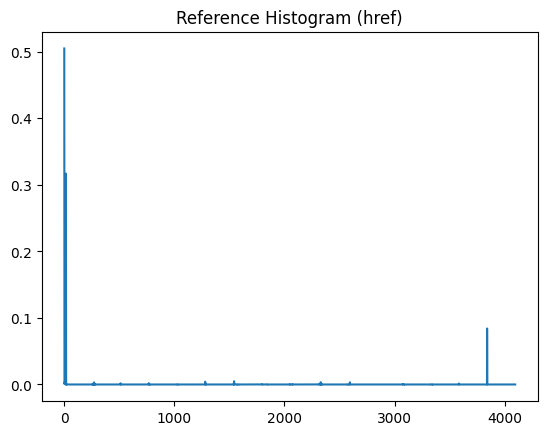

In [71]:
import numpy as np
import cv2

def compute_norm_hist(image, state, half_width, half_height):
    """
    Compute the normalized color histogram based on the RGB values of the image in the ROI defined by the state.
    Args:
        image (np.ndarray): the image containing the object to track
        state (np.ndarray): state vector of the tracked object [x_center, y_center, vx, vy]
        half_width (int): half width of the bounding box
        half_height (int): half height of the bounding box

    Returns:
        np.ndarray: normalized histogram of the colors in the ROI of the image based on the state
    """
    x_center, y_center = state[:2]

    # Get the top-left and bottom-right corner of the object bounding box
    x_min = max(int(np.round(x_center - half_width)), 0)
    x_max = min(int(np.round(x_center + half_width)), image.shape[1])
    y_min = max(int(np.round(y_center - half_height)), 0)
    y_max = min(int(np.round(y_center + half_height)), image.shape[0])

    # Extract the region of interest (ROI) from the image
    roi = image[y_min:y_max, x_min:x_max]
    
    # Reduce the range of pixel values from 0-255 to 0-15 (for computational efficiency)
    roi_reduced = roi // 16

    # Build a vector representing the combination of RGB as a single value
    roi_indexing = (roi_reduced[..., 0] + roi_reduced[..., 1] * 16 + roi_reduced[..., 2] * 16 ** 2).flatten()

    # Calculate the histogram with 4096 bins (for each combination of RGB in the reduced range)
    hist, _ = np.histogram(roi_indexing, bins=4096, range=(0, 4096))

    # Normalize the histogram to get a probability distribution
    norm_hist = hist / np.sum(hist) if np.sum(hist) > 0 else np.ones(4096) / 4096

    return norm_hist

# Example usage: Calculate the reference histogram
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Step 2: Calculate the reference histogram based on the initial state (s_init)
    href = compute_norm_hist(image, s_init, half_width, half_height)
    print("Reference histogram (href) calculated successfully.")

    # Optionally, visualize the histogram
    import matplotlib.pyplot as plt
    plt.plot(href)
    plt.title('Reference Histogram (href)')
    plt.show()

    # Close video capture
    cap.release()


Tracked area initialized successfully.
Reference histogram (href) calculated successfully.


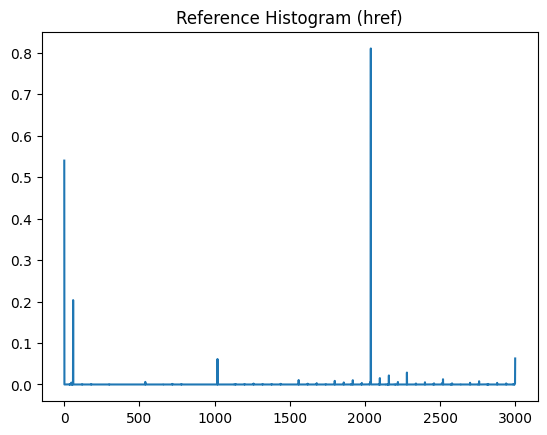

In [67]:
import numpy as np
import cv2

def compute_norm_hist(image, state, half_width, half_height):
    """
    Compute the normalized color histogram using OpenCV's calcHist function.
    Args:
        image (np.ndarray): the image containing the object to track
        state (np.ndarray): state vector of the tracked object [x_center, y_center, vx, vy]
        half_width (int): half width of the bounding box
        half_height (int): half height of the bounding box

    Returns:
        np.ndarray: normalized histogram of the colors in the ROI of the image based on the state
    """
    x_center, y_center = state[:2]

    # Get the top-left and bottom-right corners of the object bounding box
    x_min = max(int(np.round(x_center - half_width)), 0)
    x_max = min(int(np.round(x_center + half_width)), image.shape[1])
    y_min = max(int(np.round(y_center - half_height)), 0)
    y_max = min(int(np.round(y_center + half_height)), image.shape[0])

    # Extract the region of interest (ROI) from the image
    roi = image[y_min:y_max, x_min:x_max]

    # Convert the image to HSV for better color distinction (optional, but common in tracking)
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Calculate the histogram for the HSV image (only for the Hue and Saturation channels)
    hist = cv2.calcHist([roi_hsv], [0, 1], None, [50, 60], [0, 180, 0, 256])

    # Normalize the histogram to get a probability distribution
    norm_hist = cv2.normalize(hist, hist).flatten()

    return norm_hist

# Example usage: Calculate the reference histogram
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Step 2: Calculate the reference histogram based on the initial state (s_init)
    href = compute_norm_hist(image, s_init, half_width, half_height)
    print("Reference histogram (href) calculated successfully.")

    # Optionally, visualize the histogram
    import matplotlib.pyplot as plt
    plt.plot(href)
    plt.title('Reference Histogram (href)')
    plt.show()

    # Close video capture
    cap.release()

#### **Step 3:** <br>
Initialize a set of N particles by generating random positions around the center of tracked area. Initial particle weights are set to wi0 = 1, ..., N.

In [72]:
# STEP 3

def initialize_particles(s_init, num_of_particles, sigma_pos=10):
    """
    Initialize a set of particles around the initial state with random positions and velocities.

    Args:
        s_init (np.ndarray): initial state [x_center, y_center, x_velocity, y_velocity]
        num_of_particles (int): number of particles to generate
        sigma_pos (float): standard deviation for the position noise (default 10)

    Returns:
        np.ndarray: matrix of shape (4, num_of_particles) representing the particles' states
        np.ndarray: weights of each particle initialized to 1/N
    """
    # Ensure s_init is float for precision in calculations
    s_init = s_init.astype(float)
    
    # Initialize particles around the initial center with random noise
    particles = np.tile(s_init, (num_of_particles, 1)).T  # Create a 4 x num_of_particles matrix
    # Add Gaussian noise to the x, y positions (0 noise for velocity)
    particles[0] += np.random.normal(0, sigma_pos, num_of_particles)  # Perturbation on x
    particles[1] += np.random.normal(0, sigma_pos, num_of_particles)  # Perturbation on y

    # Initialize weights, each weight is 1/N
    weights = np.ones(num_of_particles) / num_of_particles

    return particles, weights

# Example usage to initialize particles after Step 1 and Step 2
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Calculate the reference histogram based on the initial state (s_init)
    href = compute_norm_hist(image, s_init, half_width, half_height)
    
    # Step 3: Initialize particles
    num_of_particles = 250
    particles, weights = initialize_particles(s_init, num_of_particles)

    print("Particles initialized successfully.")
    print("Particles shape:", particles.shape)
    print("Weights shape:", weights.shape)

    # Optional: Display the initialized particles on the image for verification
    for i in range(num_of_particles):
        x, y = int(particles[0, i]), int(particles[1, i])
        cv2.circle(image, (x, y), 3, (0, 255, 0), -1)  # Draw each particle in green

    # Show the image with particles
    cv2.imshow("Initialized Particles", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Close video capture
    cap.release()

Tracked area initialized successfully.
Particles initialized successfully.
Particles shape: (4, 250)
Weights shape: (250,)


#### **Step 4:** 
It includes 3 main steps in the Particle Filter. At every time instant k, a set of N particles with associated weights {xik, wik} i = 1, ..., N is maintained to track the object. Note that particle weights are normalized so that Sigma N i=1 (wik) = 1.
- **Prediction:** <br> 
The goal of this step is to predict the position of the tracked object using the transition model in Eq. 1.


In [84]:
# Transition function

def predict_particles(particles_states, noise_scale=1):
    """
    Predict new particles (states) based on the previous states using a transition model.
    
    Args:
        particles_states (np.ndarray): matrix of states. The rows are the properties of the state and the columns are the particles.
        noise_scale (float): standard deviation of the noise added to the predicted states.

    Returns:
        np.ndarray: new predicted particles
    """
    # Adding Gaussian noise to the predicted positions
    noise = np.random.normal(0, noise_scale, particles_states.shape)  # Noise for each dimension of the particles
    predicted_states = particles_states + noise  # Predict new states by adding noise
    
    return predicted_states

In [85]:
def draw_bounding_box(image, states, weights, with_max=True):
    """
    Draw rectangle according to the weighted average state and (optionally) a rectangle of the state with
    the maximum score.
    Args:
        image (np.ndarray): the image to draw recangle on
        states (np.ndarray): the sampling states
        weights (np.ndarray): the weight of each state
        with_max (bool): True to draw a rectangle according to the state with the highest weight

    Returns:
        (np.ndarray): image with rectangle drawn on for the tracked object
    """
    mean_box = np.average(states, axis=1, weights=weights)
    x_c_mean, y_c_mean = np.round(mean_box[:2]).astype(int)
    image_with_boxes = image.copy()
    cv2.rectangle(image_with_boxes, (x_c_mean - half_width, y_c_mean - half_height),
                                     (x_c_mean + half_width, y_c_mean + half_height), (0, 255, 0), 1)
    #if with_max:
    #    max_box = states[:, np.argmax(weights)]
    #    x_c_max, y_c_max = np.round(max_box[:2]).astype(int)
    #    cv2.rectangle(image_with_boxes, (x_c_max - half_width, y_c_max - half_height),
    #                                     (x_c_max + half_width, y_c_max + half_height), (0, 0, 255), 1)
    return image_with_boxes

def draw_particles(image, states, weights):
    """
    Draw the particles (position state) on the image with size according to the weight of the state.
    Args:
        image (np.ndarray): the image to draw particles on
        states (np.ndarray): the sampling states
        weights (np.ndarray): the weight of each state

    Returns:
        (np.ndarray): image with particles drawn on
    """
    image_with_particles = image.copy()
    for s, w in zip(states.T, weights):
        x, y = np.round(s[:2]).astype(int)
        cv2.circle(image_with_particles, (x, y), int(round(30 * w)), (0, 0, 255), thickness=-1)
    return image_with_particles

In [88]:
# Example usage to initialize particles after Step 1 and Step 2
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Calculate the reference histogram based on the initial state (s_init)
    href = compute_norm_hist(image, s_init, half_width, half_height)
    
    # Step 3: Initialize particles
    num_of_particles = 250
    particles, weights = initialize_particles(s_init, num_of_particles)

    print("Particles initialized successfully.")

    while True:
        # Step 4.1: Prediction
        particles = predict_particles(particles, noise_scale=1)  # Adjust the noise scale if necessary
        
        # Optional: Display the predicted particles on the image for verification
        for i in range(num_of_particles):
            x, y = int(particles[0, i]), int(particles[1, i])
            cv2.circle(image, (x, y), 3, (0, 255, 0), -1)  # Draw each particle in green

        # Show the image with predicted particles
        cv2.imshow("Predicted Particles", image)
        cv2.waitKey(1)  # Wait briefly to update the display

        # Read next frame
        ret, image = cap.read()
        if not ret:  # if there is no next frame to read, stop
            break

    # Close video capture
    cap.release()
    cv2.destroyAllWindows()


Tracked area initialized successfully.
Particles initialized successfully.


- **Correction :** <br>
This step is used to correct the predicted position obtained from the previous step using the observation from the current image. The likelihood function is constructed from Eqs. 2 and 3. The particle weights are then updated as :

In [78]:
def compute_weight(p, q):
    """
    Compute the weight based on Bhattacharyya coefficient between 2 normalized histograms
    Args:
        p (np.ndarray): normalized histogram
        q (np.ndarray): normalized histogram

    Returns:
        (float): weight based on Bhattacharyya coefficient between p and q
    """
    # make sure the histogram is normalized
    if not np.isclose(np.sum(p), 1):
        raise ValueError('p histogram is not normalized')
    if not np.isclose(np.sum(q), 1):
        raise ValueError('q histogram is not normalized')
    bc = np.sum(np.sqrt(p * q))  # Bhattacharyya coefficient
    return np.exp(20 * bc)

def update_particle_weights(particles_states, reference_histogram, half_width, half_height, image):
    weights = np.zeros(particles_states.shape[1])  # Initialize weights array

    for jj, state in enumerate(particles_states.T):
        # Calculate histogram for the current particle state
        p_hist = compute_norm_hist(image, state, half_width, half_height)

        if p_hist is None or reference_histogram is None:
            print(f"Warning: Histogram for particle {jj} or reference histogram is None.")
            continue

        # Calculate weight using the Bhattacharyya coefficient
        weights[jj] = compute_weight(p_hist, reference_histogram)

    if np.sum(weights) == 0:
        print("Warning: Sum of weights is zero. All weights may be invalid.")
        return np.ones(particles_states.shape[1]) / particles_states.shape[1]  # Return uniform weights if sum is zero

    return weights


In [80]:
# Example usage to initialize particles after Step 1 and Step 2
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Calculate the reference histogram based on the initial state (s_init)
    href = compute_norm_hist(image, s_init, half_width, half_height)
    
    # Step 3: Initialize particles
    num_of_particles = 250
    particles, weights = initialize_particles(s_init, num_of_particles)

    print("Particles initialized successfully.")

    while True:
        # Step 4.1: Prediction
        particles = predict_particles(particles, noise_scale=1)  # Adjust the noise scale if necessary
        
        # Step 4.2: Correction
        weights = update_particle_weights(particles, href, half_width, half_height, image)  # Update particle weights

        # Normalize weights so that their sum equals 1
        weights /= np.sum(weights)

        # Draw bounding box over the tracked object
        image_with_boxes = draw_bounding_box(image, particles, weights, with_max=True)
        result.write(image_with_boxes)

        # Read next frame
        ret, image = cap.read()
        if not ret:  # if there is no next frame to read, stop
            break

    # Close video capture
    cap.release()

Tracked area initialized successfully.
Particles initialized successfully.


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\videoio\src\cap_mjpeg_encoder.cpp:481: error: (-215:Assertion failed) imgWidth == frameWidth && imgHeight == frameHeight && channels == 3 in function 'cv::mjpeg::MotionJpegWriter::write'


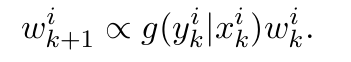

- **Resampling:** <br>
This step alleviates a common problem of Particle Filter referred to as sample degeneracy. It replicates particles with high weights and remove those with low weights. The most commonly used resampling algorithms are :

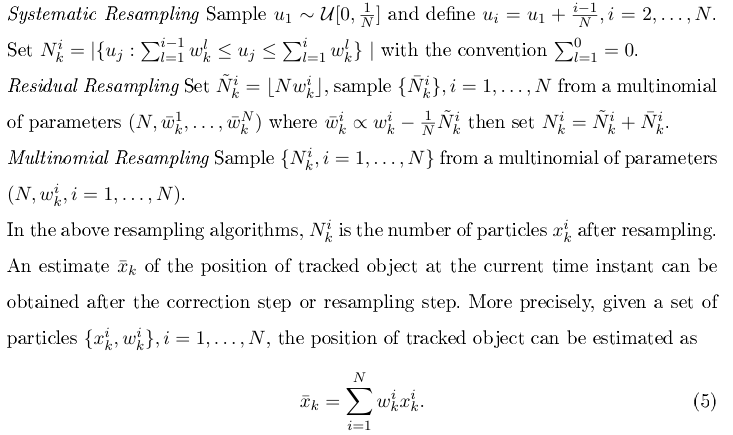

In [60]:
def resample_particles(particles_states, weights):
    """
    Resample particles based on their weights to alleviate sample degeneracy.
    
    Args:
        particles_states (np.ndarray): matrix of states. The rows are the properties of the state and the columns are the particles.
        weights (np.ndarray): weights of each state

    Returns:
        np.ndarray: resampled particles
    """
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    
    # Resample particles based on normalized weights
    indices = np.random.choice(len(weights), size=len(weights), p=normalized_weights)
    resampled_particles = particles_states[:, indices]  # Create a new particle set from the sampled indices
    
    return resampled_particles


In [61]:
# Initialize video writer to save the results
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = 20  # Set frames per second for the output video
result = cv2.VideoWriter('tracked_output.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (frame_width, frame_height))

# Example usage to initialize particles after Step 1 and Step 2
video_path = 'video sequences/synthetic/escrime-4-3-cluster.avi'
initial_position = (320, 240)  # Center of the rectangle
half_width = 50  # Half of the width of the rectangle
half_height = 50  # Half of the height of the rectangle

# Initialize the tracked area
cap, image, s_init, half_width, half_height = initialize_tracked_area(video_path, initial_position, half_width, half_height)

# Check if initialization was successful
if cap is None:
    print("Initialization failed.")
else:
    print("Tracked area initialized successfully.")
    
    # Calculate the reference histogram based on the initial state (s_init)
    href = compute_norm_hist(image, s_init, half_width, half_height)
    
    # Step 3: Initialize particles
    num_of_particles = 250
    particles, weights = initialize_particles(s_init, num_of_particles)

    print("Particles initialized successfully.")

    while True:
        # Step 4.1: Prediction
        particles = predict_particles(particles, noise_scale=1)  # Adjust the noise scale if necessary
        
        # Step 4.2: Correction
        weights = update_particle_weights(particles, href, half_width, half_height, image)  # Update particle weights

        # Normalize weights so that their sum equals 1
        weights /= np.sum(weights)

        # Step 4.3: Resampling
        particles = resample_particles(particles, weights)  # Resample particles based on weights

        # Draw bounding box over the tracked object
        image_with_boxes = draw_bounding_box(image, particles, weights, with_max=True)
        result.write(image_with_boxes)  # Write the frame with bounding box to the output video

        # Read next frame
        ret, image = cap.read()
        if not ret:  # if there is no next frame to read, stop
            break

    # Release video objects
    cap.release()
    result.release()
    print("Video tracking completed and saved as 'tracked_output.avi'.")


Tracked area initialized successfully.


TypeError: compute_norm_hist() takes 2 positional arguments but 4 were given

In [45]:
def update_particle_weights(particles_states, reference_histogram, half_width, half_height, image):
    """
    Update the weights of the particles based on the likelihood of the observed histogram.
    
    Args:
        particles_states (np.ndarray): matrix of states. The rows are the properties of the state and the columns are the particles.
        reference_histogram (np.ndarray): normalized histogram of the reference state.
        half_width (int): half width of the bounding box
        half_height (int): half height of the bounding box
        image (np.ndarray): current image for histogram calculation

    Returns:
        np.ndarray: updated weights for each particle
    """
    weights = np.zeros(particles_states.shape[1])  # Initialize weights array

    for jj, state in enumerate(particles_states.T):
        # Calculate histogram for the current particle state
        p_hist = compute_norm_hist(image, state, half_width, half_height)
        
        # Calculate weight using the Bhattacharyya coefficient
        weights[jj] = compute_weight(p_hist, reference_histogram)

    return weights


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def compute_weight(p, q):
    """
    Compute the weight based on Bhattacharyya coefficient between 2 normalized histograms
    Args:
        p (np.ndarray): normalized histogram
        q (np.ndarray): normalized histogram

    Returns:
        (float): weight based on Bhattacharyya coefficient between p and q
    """
    # make sure the histogram is normalized
    if not np.isclose(np.sum(p), 1):
        raise ValueError('p histogram is not normalized')
    if not np.isclose(np.sum(q), 1):
        raise ValueError('q histogram is not normalized')
    bc = np.sum(np.sqrt(p * q))  # Bhattacharyya coefficient
    return np.exp(20 * bc)

def compute_norm_hist(image, state):
    """
    Compute histogram based on the RGB values of the image in the ROI defined by the state.
    Args:
        image (np.ndarray): matrix representing image with the object to track in it
        state (np.ndarray): vector of the state of the tracked object

    Returns:
        vector of the normalized histogram of the colors in the ROI² of the image based on the state
    """
    # get the top-left and bottom-right corner of the object bounding box
    x_min = max(np.round(state[0] - half_width).astype(int), 0)
    x_max = min(np.round(state[0] + half_width).astype(int), image.shape[1])
    y_min = max(np.round(state[1] - half_height).astype(int), 0)
    y_max = min(np.round(state[1] + half_height).astype(int), image.shape[0])

    roi = image[y_min:y_max+1, x_min:x_max+1]
    roi_reduced = roi // 16  # change range of pixel values from 0-255 to 0-15
    # build vector to represent the combinations of RGB as a single value
    roi_indexing = (roi_reduced[..., 0] + roi_reduced[..., 1] * 16 + roi_reduced[..., 2] * 16 ** 2).flatten()
    hist, _ = np.histogram(roi_indexing, bins=4096, range=(0, 4096))
    
    # Ensure normalization of the histogram
    norm_hist = hist / np.sum(hist) if np.sum(hist) > 0 else np.ones(4096) / 4096  # uniform distribution if all zeros
    return norm_hist


def predict_particles(particles_states):
    """
    Predict new particles (states) based on the previous states
    Args:
        particles_states (np.ndarray): matrix of states. The rows are the properties of the state and the columns are the particles

    Returns:
        (np.ndarray): new predicted particles
    """
    # the dynamic we use assume that:
    # x_new = x + v_x (x - center position)
    # y_new = y + v_y (y - center position)
    # v_x_new = v_x (velocity at x)
    # v_y_new = v_y (velocity at y)
    dynamics = np.array(
        [[1 ,0, 1, 0],
         [0, 1, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 0, 1]]
    )
    # multiplying the state by the dynamics and add some noise
    predicted_states = dynamics @ particles_states + np.random.normal(loc=0, scale=1, size=particles_states.shape)
    return predicted_states

def sample_particle(particles_states, weights):
    """
    Sample the particles (states) according to their weights.
    First a random numbers from uniform distribution U~[0,1] are generated.
    The random numbers are subtracted from the cumulative sum of the weights,
    and the sampling is made by selecting the state which its cumulative weights
    sum is the minimal one which is greater than the random number. If c[i] is the
    cumulative sum of the weights for the i-th state and r is a random number, the
    state which will be sampled is the j-th state so c[j] >= r and also c[j] is
    the smaller one that hold this inequality.
    Args:
        particles_states (np.ndarray): matrix which its columns are the states
        weights (np.ndarray): weights of each state

    Returns:
        (np.ndarray): matrix of sampled states according to their weights
    """
    normalized_weights = weights / np.sum(weights)
    sampling_weights = np.cumsum(normalized_weights)
    rand_numbers = np.random.random(sampling_weights.size)  # get random numbers from U~[0,1]
    cross_diff = sampling_weights[None, :] - rand_numbers[:, None]  # subtract from each weight any of the random numbers
    cross_diff[cross_diff < 0] = np.inf  # remove negative results
    sampling = np.argmin(cross_diff, axis=1)
    sampled_particles = particles_states[:, sampling]  # sample the particles
    return sampled_particles

def draw_bounding_box(image, states, weights, with_max=True):
    """
    Draw rectangle according to the weighted average state and (optionally) a rectangle of the state with
    the maximum score.
    Args:
        image (np.ndarray): the image to draw recangle on
        states (np.ndarray): the sampling states
        weights (np.ndarray): the weight of each state
        with_max (bool): True to draw a rectangle according to the state with the highest weight

    Returns:
        (np.ndarray): image with rectangle drawn on for the tracked object
    """
    mean_box = np.average(states, axis=1, weights=weights)
    x_c_mean, y_c_mean = np.round(mean_box[:2]).astype(int)
    image_with_boxes = image.copy()
    cv2.rectangle(image_with_boxes, (x_c_mean - half_width, y_c_mean - half_height),
                                     (x_c_mean + half_width, y_c_mean + half_height), (0, 255, 0), 1)
    #if with_max:
    #    max_box = states[:, np.argmax(weights)]
    #    x_c_max, y_c_max = np.round(max_box[:2]).astype(int)
    #    cv2.rectangle(image_with_boxes, (x_c_max - half_width, y_c_max - half_height),
    #                                     (x_c_max + half_width, y_c_max + half_height), (0, 0, 255), 1)
    return image_with_boxes

def draw_particles(image, states, weights):
    """
    Draw the particles (position state) on the image with size according to the weight of the state.
    Args:
        image (np.ndarray): the image to draw particles on
        states (np.ndarray): the sampling states
        weights (np.ndarray): the weight of each state

    Returns:
        (np.ndarray): image with particles drawn on
    """
    image_with_particles = image.copy()
    for s, w in zip(states.T, weights):
        x, y = np.round(s[:2]).astype(int)
        cv2.circle(image_with_particles, (x, y), int(round(30 * w)), (0, 0, 255), thickness=-1)
    return image_with_particles

# create video reader object and read te first frame
cap = cv2.VideoCapture('video sequences/synthetic/escrime-4-3-cluster.avi')
ret, image = cap.read()

num_of_particles = 250
# s_init = np.array([375, 198, 0, 0])  # initial state [x_center, y_center, x_velocity, y_velocity]
s_init = np.array([320, 240, 0, 0])  # initial state [x_center, y_center, x_velocity, y_velocity]

# bounding box's (half) height and width.
# We assume those are constant
half_height = 50
half_width = 50

# get parameters of the video
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = 20 #cap.get(5)  # frames per second

# create a video writer object
size = (frame_width, frame_height)
result = cv2.VideoWriter('test.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         fps, size)
# get the normalized histogram of the initial state
# this histogram is the histogram we compare to later
q = compute_norm_hist(image, s_init)

# for the first frame all the particle are the same as the initial state
# and have the same weight since we don't have uncertainty in the state
s_new = np.tile(s_init, (num_of_particles, 1)).T
weights = np.ones(num_of_particles)

# go over the frames in the video
while True:
    # sample new particles according to the weights
    s_sampled = sample_particle(s_new, weights)
    # predict new particles (states) according to the previous states
    s_new = predict_particles(s_sampled)
    # go over the new predicted states, and compute the histogram for the state and
    # the weight with the original histogram
    for jj, s in enumerate(s_new.T):
        p = compute_norm_hist(image, s)
        weights[jj] = compute_weight(p, q)

    # draw bounding box over the tracked object
    image_with_boxes = draw_bounding_box(image, s_new, weights, with_max=True)
    # image_with_particles = draw_particles(image_with_boxes, s_sampled, normalized_weights)
    result.write(image_with_boxes)

    # read next frame
    ret, image = cap.read()
    if not ret:  # if there is no next frame to read, stop
        break

# release video objects
cap.release()
result.release()

### 1.2 Practical Work

- Implement the Particle Filter algorithm described in the previous section to track a moving object in a video sequence.
- Test your tracker with di erent settings of parameters : (transition model), (likelihood model), Nb (color histogram), N (number of particles). Implementation of the systematic resampling algorithm is mandatory. The other two resampling algorithms are optional (you'll get bonus points if you implement them).
- Test your tracker with a reduced number of video frames (e.g., remove one frame for every two consecutive frames). Compare the accuracy of your tracker in the two cases (tracking the object in the original video and in the video with a reduced number of frames). Which components (parameters, algorithms) you should change in order for the tracker to work?
- The size of object is now assumed to be varied during tracking. Adapt your tracker to this scenario. What do you observe in terms of tracking accuracy? Why?
- Propose some other methods for constructing the likelihood model. Compare the performance (accuracy, computation time) of your tracker when using di erent likelihood models.
- In order to made a thorough study on the performance of your tracker, you are asked to test it on your own videos. For simplicity, you might create a square/rectangle/circle/triangle that moves in a video. Di erent levels of di culties can be added to investigate the robustness of your tracker :
- Vary the moving spead of objects.
- Objects lled with more colors.
- Clustered background videos instead of clean background ones.
- Videos with multiple moving objects. What do you observe when some objects are
 occluded by some others? Propose a solution to deal with the problem.

By creating your own videos, you'll be able to calculate the tracking errors by comparing the positions of tracked object estimated by your tracker with the groundtruth positions. <br>
Plot the tracker accuracy over time for di erent cases considered above.